In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
from src.smalldiffusion.diffusion import ScheduleLogLinear, classifier_free_guidance_training_loop, conditioned_samples
from src.smalldiffusion.data import StarDataset
from src.smalldiffusion.model import (
    TimeInputMLPConditional, get_sigma_embeds
)


import torch
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

def plot_batch(batch, label=None, marker='.'):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker=marker, label=label)
    # plt.xlim(-4,4)
    # plt.ylim(-4,4)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w



torch.Size([10000]) torch.Size([10000]) torch.Size([10000])


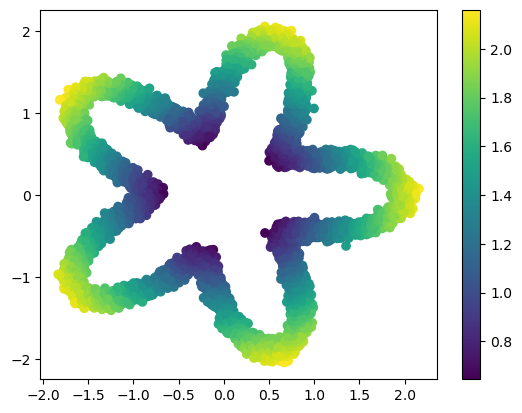

In [158]:
dataset = StarDataset(radius=2, n_points=10000, seed=0)
loader = DataLoader(dataset, batch_size=100, shuffle=True)
print(dataset.data[:, 0].shape, dataset.data[:, 1].shape, dataset.radii[:, 0].shape)
fig, ax = plt.subplots()
im = ax.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0])
fig.colorbar(im, ax=ax)
plt.show()

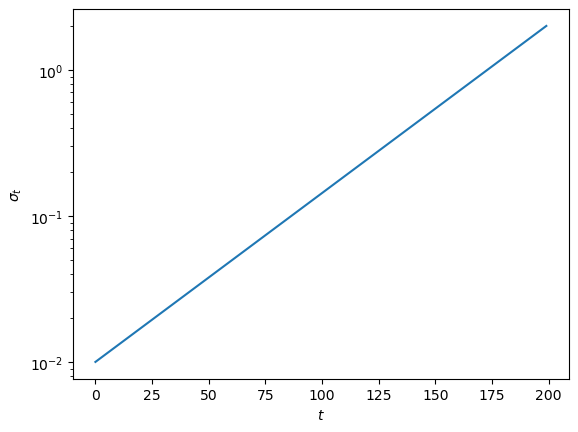

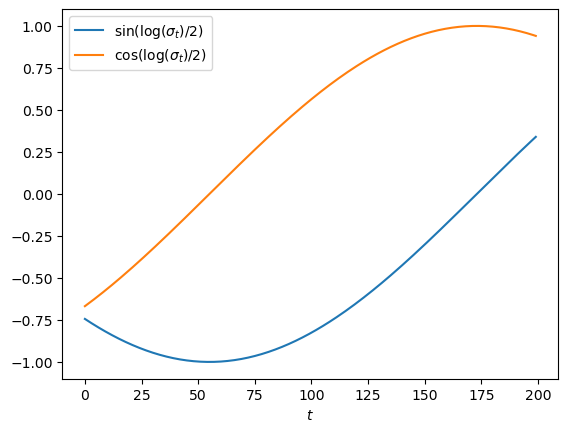

In [173]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=2)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')
plt.show()

sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [174]:
model = TimeInputMLPConditional(dim=2, cond_dim=1, cond_hid_dim=16, hidden_dims=(16,128,256,128,16))
trainer = classifier_free_guidance_training_loop(loader, model, schedule, epochs=1000, lr=1e-3, drop_prob=0.2)
losses = [ns.loss.item() for ns in trainer]

loss: 0.3678: 100%|██████████| 1000/1000 [04:16<00:00,  3.90it/s]


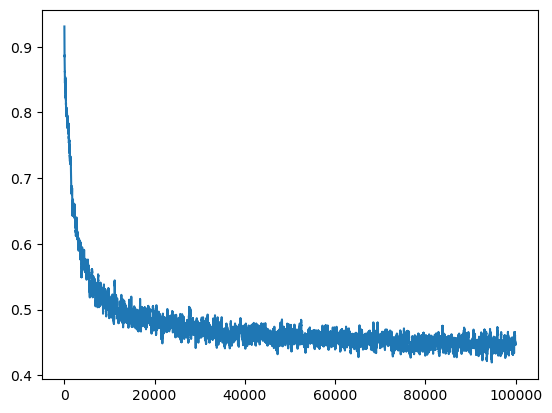

In [175]:
plt.plot(moving_average(losses, 100))
plt.show()

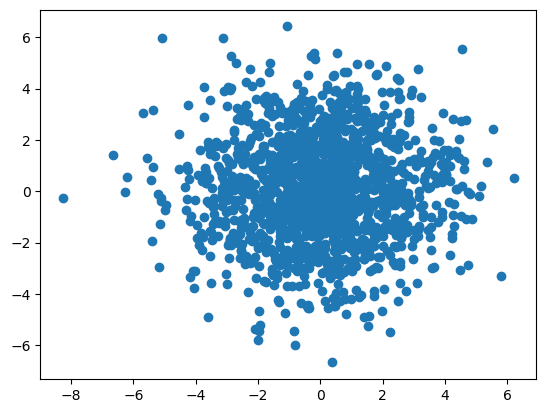

In [176]:
xT = model.rand_input(1500)* schedule.sample_sigmas(50)[0]
plt.scatter(xT[:,0], xT[:,1])

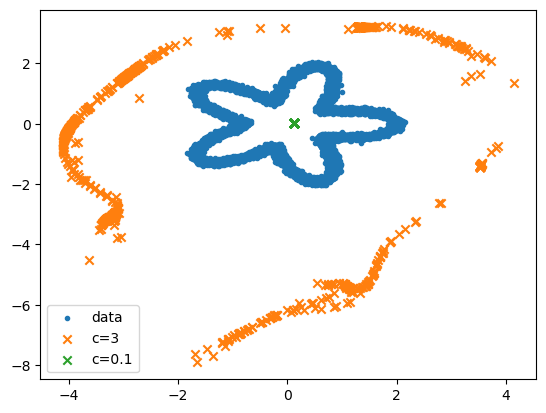

In [182]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
plot_batch(dataset.data, label='data', marker='.')
# plt.scatter(dataset.data[:, 0], dataset.data[:, 1], c=dataset.radii[:, 0], label='data')

guide_w = 2.0
gam=1
mu=0
steps=50
# conditions = torch.ones(1500,1)*10
# conditions = None
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=none', marker='.')

conditions = torch.ones(1500,1)*3
*xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
plot_batch(x0, label='c=3', marker='x')

# conditions = torch.ones(1500,1)*2
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=2', marker='x')

# conditions = torch.ones(1500,1)*1
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1', marker='x')

# conditions = torch.ones(1500,1)*1.75
# *xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
# plot_batch(x0, label='c=1.75', marker='x')

conditions = torch.ones(1500,1)*0.1
*xts, x0 = conditioned_samples(model, schedule.sample_sigmas(steps), batchsize=1500, gam=gam, mu=mu, guide_w=guide_w, c=conditions)
plot_batch(x0, label='c=0.1', marker='x')

plt.legend()

